## Pseudotime calculation using pySlingshot

- source: https://github.com/mossjacob/pyslingshot/blob/master/slingshot.ipynb 
- last updated: 05/14/2024




In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyslingshot import Slingshot

import scanpy as sc
import anndata as ad

## test with a sample dataset

In [2]:
adata = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR126/TDR126_processed_RNA.h5ad")
adata

AnnData object with n_obs × n_vars = 15036 × 32057
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.unassigned', 'prediction.score.Neural_Anterior', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.PSM', 'prediction.score.Neural_Posterior', 'prediction.score.Epidermal', 'prediction.score.Somites', 'prediction.score.NMPs', 'prediction.score.Endoderm', 'prediction.score.Muscle', 'prediction.score.Notochord', 'prediction.score.Differentiating_Neurons', 'prediction.score.Germline', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity'
    var: 'features'
    obsm: 'X_umap

In [9]:
# Load the master annotation from Merlin Lange
annotation = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/annotations/multiome_integrated_05202024.txt", index_col=0, sep="\t")
annotation.head()

,dataset,scANVI_identity_sub,scANVI_identity_super,manual_annotation,annotation_ML,global_annotation,tissue
AAACAGCCACCTAAGC-1_1,TDR118,oral _ pharyngeal epithelium (earlier),epidermis_placodal ectoderm,Epidermal,epidermis,Epidermal,epidermis
AAACAGCCAGGGAGGA-1_1,TDR118,myocardium,mixed signature,Lateral_Mesoderm,pronephros,Lateral_Mesoderm,muscle
AAACAGCCATAGACCC-1_1,TDR118,vacuolar cells (14-18 hpf),presomitic mesoderm,PSM,hindbrain,PSM,presomitic mesoderm
AAACATGCAAACTCAT-1_1,TDR118,late tubule + pronephric duct,oligodendrocytes,Neural_Posterior,axial_mesoderm,Neural_Posterior,glial
AAACATGCAAGGACCA-1_1,TDR118,21-36 hpf,floor plate,Neural_Anterior,neural_optic2,Neural_Anterior,spinal cord


In [ ]:
adata.obs

In [8]:
adata.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC',
       'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile',
       'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT',
       'global_annotation', 'prediction.score.unassigned',
       'prediction.score.Neural_Anterior', 'prediction.score.Lateral_Mesoderm',
       'prediction.score.Neural_Crest', 'prediction.score.PSM',
       'prediction.score.Neural_Posterior', 'prediction.score.Epidermal',
       'prediction.score.Somites', 'prediction.score.NMPs',
       'prediction.score.Endoderm', 'prediction.score.Muscle',
       'prediction.score.Notochord',
       'prediction.score.Differentiating_Neurons', 'prediction.score.Germline',
       'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk',
       'nCount_peaks_celltype', 'nFeature_peaks_celltype',
       'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight',
       'peaks_merged.weight', 'nCount_Gene.Activity',
       'nFeature_

In [8]:
# Assuming 'manual_annotation' contains the categories as shown
categories = adata.obs['manual_annotation'].cat.categories

# Create a dictionary mapping each category to an integer
category_to_integer = {category: i for i, category in enumerate(categories)}

# Print the mapping to verify
print(category_to_integer)

{'Muscle': 0, 'NMPs': 1, 'Neural_Anterior': 2, 'Neural_Posterior': 3, 'PSM': 4, 'Somites': 5}


In [10]:
# Replace the categorical labels in the DataFrame with the mapped integers
adata.obs['manual_annotation_integer'] = adata.obs['manual_annotation'].map(category_to_integer)

# # Check the new column to ensure the mapping is correct
# print(adata.obs.head())

In [19]:
# Convert categorical labels to integer codes
adata.obs['manual_annotation_integer'] = adata.obs['manual_annotation'].cat.codes

# Check the new column to ensure the mapping is correct and the datatype
print(adata.obs['manual_annotation_integer'].head())
print(adata.obs['manual_annotation_integer'].dtype)

AAACAGCCATAGACCC-1    3
AAACATGCAAACTCAT-1    3
AAACATGCAAGGACCA-1    2
AAACATGCAAGGATTA-1    2
AAACATGCAGGACCTT-1    4
Name: manual_annotation_integer, dtype: int8
int8


In [20]:
# # Get the category labels
# categories = adata.obs['manual_annotation'].cat.categories

# # Get the integer codes
# codes = adata.obs['manual_annotation'].cat.codes.unique()

# # Create a dictionary from categories to codes
# category_to_code_map = dict(zip(categories, codes))

# # Print the mapping to verify
# print(category_to_code_map)

{'Muscle': 3, 'NMPs': 2, 'Neural_Anterior': 4, 'Neural_Posterior': 0, 'PSM': 5, 'Somites': 1}


/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/pyslingshot/util.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isint(cluster_labels[0]):


Lineages: [Lineage[1, 3, 2], Lineage[1, 4, 5, 0]]


  0%|          | 0/1 [00:00<?, ?it/s]/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/pyslingshot/slingshot.py:333: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D


Reversing from leaf to root
Averaging branch @1 with lineages: [0, 1] [<pcurvepy2.pcurve.PrincipalCurve object at 0x14bdd23b60b0>, <pcurvepy2.pcurve.PrincipalCurve object at 0x14bdd227b460>]
Shrinking branch @1 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x14bdd23b60b0>, <pcurvepy2.pcurve.PrincipalCurve object at 0x14bdd227b460>]


100%|██████████| 1/1 [00:46<00:00, 46.50s/it]


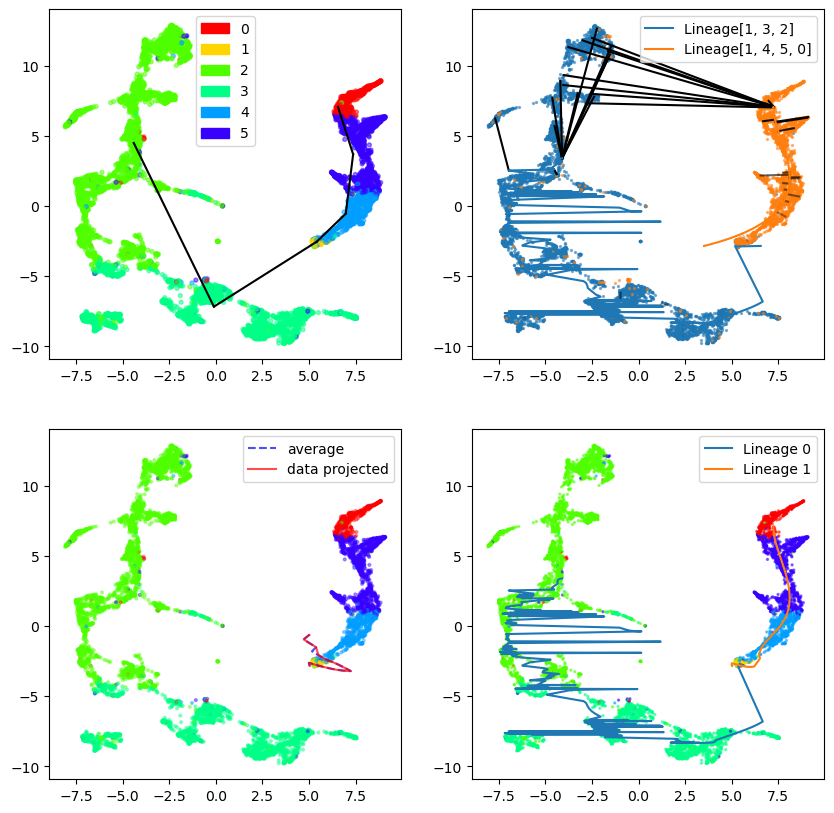

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)
# plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

slingshot = Slingshot(adata, celltype_key="manual_annotation_integer", 
                      obsm_key="X_umap_aligned", start_node=1, 
                      debug_level='verbose')

slingshot.fit(num_epochs=1, debug_axes=axes)

In [ ]:
fig.savefig

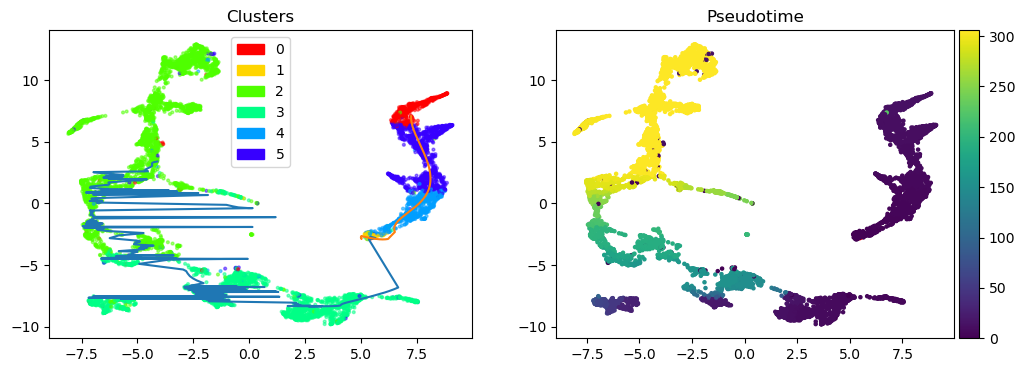

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].set_title('Clusters')
axes[1].set_title('Pseudotime')
slingshot.plotter.curves(axes[0], slingshot.curves)
slingshot.plotter.clusters(axes[0], labels=np.arange(slingshot.num_clusters), s=4, alpha=0.5)
slingshot.plotter.clusters(axes[1], color_mode='pseudotime', s=5)

### get Pseudotime

In [26]:
# NOTE: the Slingshot class has a property which has the pseudotime that is used to 
# color the plot above
pseudotime = slingshot.unified_pseudotime
pseudotime

array([ 28.66250219,   6.99793257, 305.62432148, ..., 305.62432148,
       161.04768423, 305.62432148])

In [27]:
len(pseudotime)

8237

### map the pseudotime into adata object

In [36]:
adata

AnnData object with n_obs × n_vars = 8237 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'manual_annotation', 'manual_annotation_integer'
    var: 'features'
    uns: 'global_annotation_colors', 'manual_annotation_colors'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna', 'X_umap_aligned'

In [37]:
adata.obs["Pseudotime"] = pseudotime

In [38]:
adata.obs.head()

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,nFeature_peaks_celltype,nCount_peaks_merged,nFeature_peaks_merged,SCT_weight,peaks_merged_weight,nCount_Gene_Activity,nFeature_Gene_Activity,manual_annotation,manual_annotation_integer,Pseudotime
AAACAGCCATAGACCC-1,0,12581.0,3467,51485.0,19874,0.514213,0.24,5.238692,0.92,5781.0,...,19930,29548.0,21333,0.572315,0.427685,26083.0,10345,Neural_Posterior,3,28.662502
AAACATGCAAACTCAT-1,0,5642.0,2145,19812.0,9183,0.673319,0.85,4.409525,0.41,5363.0,...,9116,11621.0,9939,0.481765,0.518235,11748.0,6534,Neural_Posterior,3,6.997933
AAACATGCAAGGACCA-1,0,2691.0,838,5182.0,2565,0.394904,0.06,4.939061,0.83,4727.0,...,2559,2983.0,2761,0.408465,0.591535,3061.0,2376,Neural_Anterior,2,305.624321
AAACATGCAAGGATTA-1,0,4233.0,1703,24072.0,10949,0.642451,0.72,4.636479,0.62,4729.0,...,10983,13992.0,11828,0.607841,0.392159,13152.0,7376,Neural_Anterior,2,183.908195
AAACATGCAGGACCTT-1,0,14247.0,3236,8685.0,4214,0.477004,0.18,4.089459,0.17,5540.0,...,4319,5313.0,4784,0.479407,0.520593,5882.0,3931,PSM,4,5.059997


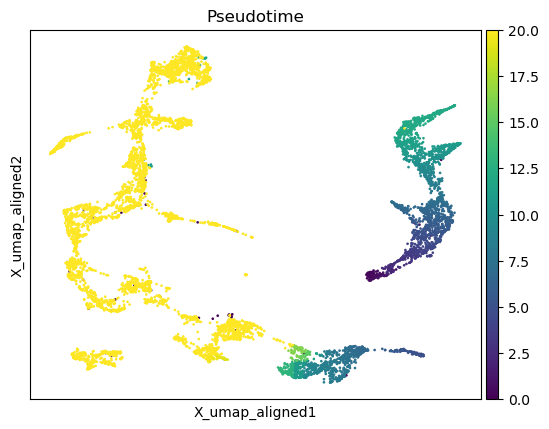

In [43]:
sc.pl.embedding(adata, basis="X_umap_aligned",
                color="Pseudotime", vmax=20)

In [49]:
# add the columns for lineages (mesoderm/neuroectoderm) - used later in CellOracle
Lineage_Meso = ["NMPs","PSM","Somites","Muscle"]
Lineage_NeuroEcto = ["NMPs", "Neural_Posterior", "Neural_Anterior"]

adata.obs["Lineage_Meso"] = adata.obs.manual_annotation.isin(Lineage_Meso)
adata.obs["Lineage_NeuroEcto"] = adata.obs.manual_annotation.isin(Lineage_NeuroEcto)

In [50]:
adata.obs["Lineage_Meso"] = adata.obs.manual_annotation.isin(Lineage_Meso)
adata.obs["Lineage_NeuroEcto"] = adata.obs.manual_annotation.isin(Lineage_NeuroEcto)

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,nFeature_peaks_merged,SCT_weight,peaks_merged_weight,nCount_Gene_Activity,nFeature_Gene_Activity,manual_annotation,manual_annotation_integer,Pseudotime,Lineage_Meso,Lineage_NeuroEcto
AAACAGCCATAGACCC-1,0,12581.0,3467,51485.0,19874,0.514213,0.24,5.238692,0.92,5781.0,...,21333,0.572315,0.427685,26083.0,10345,Neural_Posterior,3,28.662502,False,True
AAACATGCAAACTCAT-1,0,5642.0,2145,19812.0,9183,0.673319,0.85,4.409525,0.41,5363.0,...,9939,0.481765,0.518235,11748.0,6534,Neural_Posterior,3,6.997933,False,True
AAACATGCAAGGACCA-1,0,2691.0,838,5182.0,2565,0.394904,0.06,4.939061,0.83,4727.0,...,2761,0.408465,0.591535,3061.0,2376,Neural_Anterior,2,305.624321,False,True
AAACATGCAAGGATTA-1,0,4233.0,1703,24072.0,10949,0.642451,0.72,4.636479,0.62,4729.0,...,11828,0.607841,0.392159,13152.0,7376,Neural_Anterior,2,183.908195,False,True
AAACATGCAGGACCTT-1,0,14247.0,3236,8685.0,4214,0.477004,0.18,4.089459,0.17,5540.0,...,4784,0.479407,0.520593,5882.0,3931,PSM,4,5.059997,True,False


In [51]:
# Fill in Pseudotime for Lineage_Meso where Lineage_Meso is True
adata.obs['Pseudotime_Lineage_Meso'] = adata.obs['Pseudotime'].where(adata.obs['Lineage_Meso'], np.nan)

# Fill in Pseudotime for Lineage_NeuroEcto where Lineage_NeuroEcto is True
adata.obs['Pseudotime_Lineage_NeuroEcto'] = adata.obs['Pseudotime'].where(adata.obs['Lineage_NeuroEcto'], np.nan)

In [52]:
adata.obs.head()

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,peaks_merged_weight,nCount_Gene_Activity,nFeature_Gene_Activity,manual_annotation,manual_annotation_integer,Pseudotime,Lineage_Meso,Lineage_NeuroEcto,Pseudotime_Lineage_Meso,Pseudotime_Lineage_NeuroEcto
AAACAGCCATAGACCC-1,0,12581.0,3467,51485.0,19874,0.514213,0.24,5.238692,0.92,5781.0,...,0.427685,26083.0,10345,Neural_Posterior,3,28.662502,False,True,NaN,28.662502
AAACATGCAAACTCAT-1,0,5642.0,2145,19812.0,9183,0.673319,0.85,4.409525,0.41,5363.0,...,0.518235,11748.0,6534,Neural_Posterior,3,6.997933,False,True,NaN,6.997933
AAACATGCAAGGACCA-1,0,2691.0,838,5182.0,2565,0.394904,0.06,4.939061,0.83,4727.0,...,0.591535,3061.0,2376,Neural_Anterior,2,305.624321,False,True,NaN,305.624321
AAACATGCAAGGATTA-1,0,4233.0,1703,24072.0,10949,0.642451,0.72,4.636479,0.62,4729.0,...,0.392159,13152.0,7376,Neural_Anterior,2,183.908195,False,True,NaN,183.908195
AAACATGCAGGACCTT-1,0,14247.0,3236,8685.0,4214,0.477004,0.18,4.089459,0.17,5540.0,...,0.520593,5882.0,3931,PSM,4,5.059997,True,False,5.059997,NaN


In [53]:
adata.obs.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/TDR118reseq_NMPs_slingshot.csv")


## testing on another dataset where DPT underperformed



In [75]:
import os

os.listdir("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/")


['TDR124reseq',
 'TDR125reseq_NMPs.h5ad',
 'TDR125reseq',
 'TDR124reseq_NMPs.h5ad',
 'TDR118reseq_NMPs_slingshot.csv',
 'TDR128',
 'TDR118reseq',
 'TDR118reseq_NMPs.h5ad',
 'TDR127_NMPs.h5ad',
 'TDR126_NMPs.h5ad',
 'TDR128_NMPs.h5ad',
 'TDR126',
 'TDR127']

In [64]:
adata = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/TDR126_NMPs.h5ad")
adata

AnnData object with n_obs × n_vars = 9157 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'manual_annotation'
    var: 'features'
    uns: 'global_annotation_colors', 'manual_annotation_colors'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna', 'X_umap_aligned'

In [65]:
# Assuming 'manual_annotation' contains the categories as shown
categories = adata.obs['manual_annotation'].cat.categories

# Create a dictionary mapping each category to an integer
category_to_integer = {category: i for i, category in enumerate(categories)}

# Print the mapping to verify
print(category_to_integer)

{'Muscle': 0, 'NMPs': 1, 'Neural_Anterior': 2, 'Neural_Posterior': 3, 'PSM': 4, 'Somites': 5}


In [66]:
# Replace the categorical labels in the DataFrame with the mapped integers
adata.obs['manual_annotation_integer'] = adata.obs['manual_annotation'].map(category_to_integer)

# # Check the new column to ensure the mapping is correct
# print(adata.obs.head())

In [67]:
# Convert categorical labels to integer codes
adata.obs['manual_annotation_integer'] = adata.obs['manual_annotation'].cat.codes

# Check the new column to ensure the mapping is correct and the datatype
print(adata.obs['manual_annotation_integer'].head())
print(adata.obs['manual_annotation_integer'].dtype)

AAACAGCCAAACGGGC-1    3
AAACAGCCAACACTTG-1    3
AAACAGCCACAATGCC-1    5
AAACAGCCACCTGGTG-1    3
AAACAGCCAGTTATCG-1    1
Name: manual_annotation_integer, dtype: int8
int8


In [20]:
# # Get the category labels
# categories = adata.obs['manual_annotation'].cat.categories

# # Get the integer codes
# codes = adata.obs['manual_annotation'].cat.codes.unique()

# # Create a dictionary from categories to codes
# category_to_code_map = dict(zip(categories, codes))

# # Print the mapping to verify
# print(category_to_code_map)

{'Muscle': 3, 'NMPs': 2, 'Neural_Anterior': 4, 'Neural_Posterior': 0, 'PSM': 5, 'Somites': 1}


/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/pyslingshot/util.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isint(cluster_labels[0]):


Lineages: [Lineage[1, 3, 2], Lineage[1, 4, 5, 0]]


  0%|          | 0/1 [00:00<?, ?it/s]/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/pyslingshot/slingshot.py:333: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D


Reversing from leaf to root
Averaging branch @1 with lineages: [0, 1] [<pcurvepy2.pcurve.PrincipalCurve object at 0x14bdd05dca60>, <pcurvepy2.pcurve.PrincipalCurve object at 0x14bdd05dcaf0>]
Shrinking branch @1 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x14bdd05dca60>, <pcurvepy2.pcurve.PrincipalCurve object at 0x14bdd05dcaf0>]


100%|██████████| 1/1 [00:56<00:00, 56.15s/it]


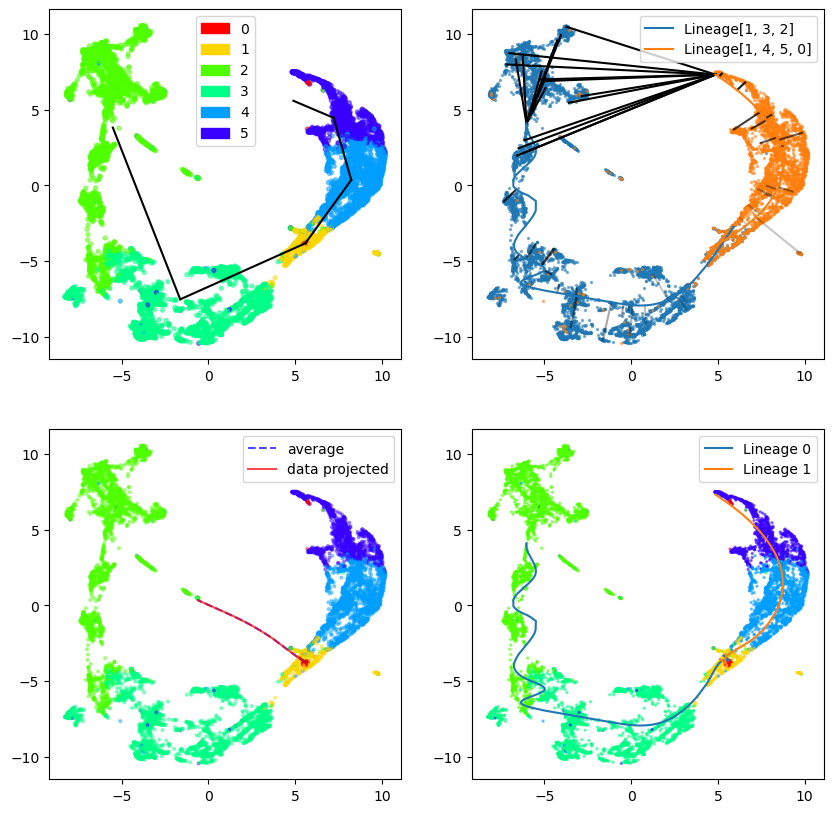

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)
# plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

slingshot = Slingshot(adata, celltype_key="manual_annotation_integer", 
                      obsm_key="X_umap_aligned", start_node=1, 
                      debug_level='verbose')

slingshot.fit(num_epochs=1, debug_axes=axes)

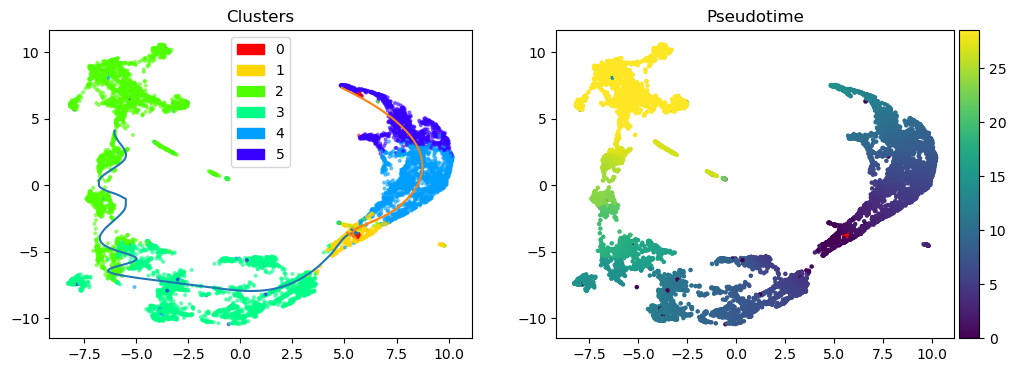

In [69]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].set_title('Clusters')
axes[1].set_title('Pseudotime')
slingshot.plotter.curves(axes[0], slingshot.curves)
slingshot.plotter.clusters(axes[0], labels=np.arange(slingshot.num_clusters), s=4, alpha=0.5)
slingshot.plotter.clusters(axes[1], color_mode='pseudotime', s=5)

### get Pseudotime

In [26]:
# NOTE: the Slingshot class has a property which has the pseudotime that is used to 
# color the plot above
pseudotime = slingshot.unified_pseudotime
pseudotime

array([ 28.66250219,   6.99793257, 305.62432148, ..., 305.62432148,
       161.04768423, 305.62432148])

In [27]:
len(pseudotime)

8237

### map the pseudotime into adata object

In [36]:
adata

AnnData object with n_obs × n_vars = 8237 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'manual_annotation', 'manual_annotation_integer'
    var: 'features'
    uns: 'global_annotation_colors', 'manual_annotation_colors'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna', 'X_umap_aligned'

In [37]:
adata.obs["Pseudotime"] = pseudotime

In [38]:
adata.obs.head()

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,nFeature_peaks_celltype,nCount_peaks_merged,nFeature_peaks_merged,SCT_weight,peaks_merged_weight,nCount_Gene_Activity,nFeature_Gene_Activity,manual_annotation,manual_annotation_integer,Pseudotime
AAACAGCCATAGACCC-1,0,12581.0,3467,51485.0,19874,0.514213,0.24,5.238692,0.92,5781.0,...,19930,29548.0,21333,0.572315,0.427685,26083.0,10345,Neural_Posterior,3,28.662502
AAACATGCAAACTCAT-1,0,5642.0,2145,19812.0,9183,0.673319,0.85,4.409525,0.41,5363.0,...,9116,11621.0,9939,0.481765,0.518235,11748.0,6534,Neural_Posterior,3,6.997933
AAACATGCAAGGACCA-1,0,2691.0,838,5182.0,2565,0.394904,0.06,4.939061,0.83,4727.0,...,2559,2983.0,2761,0.408465,0.591535,3061.0,2376,Neural_Anterior,2,305.624321
AAACATGCAAGGATTA-1,0,4233.0,1703,24072.0,10949,0.642451,0.72,4.636479,0.62,4729.0,...,10983,13992.0,11828,0.607841,0.392159,13152.0,7376,Neural_Anterior,2,183.908195
AAACATGCAGGACCTT-1,0,14247.0,3236,8685.0,4214,0.477004,0.18,4.089459,0.17,5540.0,...,4319,5313.0,4784,0.479407,0.520593,5882.0,3931,PSM,4,5.059997


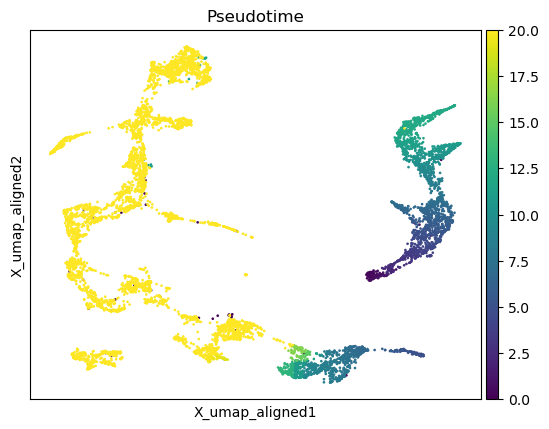

In [43]:
sc.pl.embedding(adata, basis="X_umap_aligned",
                color="Pseudotime", vmax=20)

In [49]:
# add the columns for lineages (mesoderm/neuroectoderm) - used later in CellOracle
Lineage_Meso = ["NMPs","PSM","Somites","Muscle"]
Lineage_NeuroEcto = ["NMPs", "Neural_Posterior", "Neural_Anterior"]

adata.obs["Lineage_Meso"] = adata.obs.manual_annotation.isin(Lineage_Meso)
adata.obs["Lineage_NeuroEcto"] = adata.obs.manual_annotation.isin(Lineage_NeuroEcto)

In [50]:
adata.obs["Lineage_Meso"] = adata.obs.manual_annotation.isin(Lineage_Meso)
adata.obs["Lineage_NeuroEcto"] = adata.obs.manual_annotation.isin(Lineage_NeuroEcto)

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,nFeature_peaks_merged,SCT_weight,peaks_merged_weight,nCount_Gene_Activity,nFeature_Gene_Activity,manual_annotation,manual_annotation_integer,Pseudotime,Lineage_Meso,Lineage_NeuroEcto
AAACAGCCATAGACCC-1,0,12581.0,3467,51485.0,19874,0.514213,0.24,5.238692,0.92,5781.0,...,21333,0.572315,0.427685,26083.0,10345,Neural_Posterior,3,28.662502,False,True
AAACATGCAAACTCAT-1,0,5642.0,2145,19812.0,9183,0.673319,0.85,4.409525,0.41,5363.0,...,9939,0.481765,0.518235,11748.0,6534,Neural_Posterior,3,6.997933,False,True
AAACATGCAAGGACCA-1,0,2691.0,838,5182.0,2565,0.394904,0.06,4.939061,0.83,4727.0,...,2761,0.408465,0.591535,3061.0,2376,Neural_Anterior,2,305.624321,False,True
AAACATGCAAGGATTA-1,0,4233.0,1703,24072.0,10949,0.642451,0.72,4.636479,0.62,4729.0,...,11828,0.607841,0.392159,13152.0,7376,Neural_Anterior,2,183.908195,False,True
AAACATGCAGGACCTT-1,0,14247.0,3236,8685.0,4214,0.477004,0.18,4.089459,0.17,5540.0,...,4784,0.479407,0.520593,5882.0,3931,PSM,4,5.059997,True,False


In [51]:
# Fill in Pseudotime for Lineage_Meso where Lineage_Meso is True
adata.obs['Pseudotime_Lineage_Meso'] = adata.obs['Pseudotime'].where(adata.obs['Lineage_Meso'], np.nan)

# Fill in Pseudotime for Lineage_NeuroEcto where Lineage_NeuroEcto is True
adata.obs['Pseudotime_Lineage_NeuroEcto'] = adata.obs['Pseudotime'].where(adata.obs['Lineage_NeuroEcto'], np.nan)

In [52]:
adata.obs.head()

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,peaks_merged_weight,nCount_Gene_Activity,nFeature_Gene_Activity,manual_annotation,manual_annotation_integer,Pseudotime,Lineage_Meso,Lineage_NeuroEcto,Pseudotime_Lineage_Meso,Pseudotime_Lineage_NeuroEcto
AAACAGCCATAGACCC-1,0,12581.0,3467,51485.0,19874,0.514213,0.24,5.238692,0.92,5781.0,...,0.427685,26083.0,10345,Neural_Posterior,3,28.662502,False,True,NaN,28.662502
AAACATGCAAACTCAT-1,0,5642.0,2145,19812.0,9183,0.673319,0.85,4.409525,0.41,5363.0,...,0.518235,11748.0,6534,Neural_Posterior,3,6.997933,False,True,NaN,6.997933
AAACATGCAAGGACCA-1,0,2691.0,838,5182.0,2565,0.394904,0.06,4.939061,0.83,4727.0,...,0.591535,3061.0,2376,Neural_Anterior,2,305.624321,False,True,NaN,305.624321
AAACATGCAAGGATTA-1,0,4233.0,1703,24072.0,10949,0.642451,0.72,4.636479,0.62,4729.0,...,0.392159,13152.0,7376,Neural_Anterior,2,183.908195,False,True,NaN,183.908195
AAACATGCAGGACCTT-1,0,14247.0,3236,8685.0,4214,0.477004,0.18,4.089459,0.17,5540.0,...,0.520593,5882.0,3931,PSM,4,5.059997,True,False,5.059997,NaN


In [53]:
adata.obs.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/TDR118reseq_NMPs_slingshot.csv")


## [updated 5/14/2024] Revisiting TDR125reseq and TDR124reseq (20-, and 30-somites, respectively)

These timepoints were very noisy with pySlingshot, as the clusters were very coarse-grained. We'll re-run pySlingshot with fine-grained clusters.

### TDR125reseq (20-somites)

In [2]:
adata = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/TDR125reseq_NMPs.h5ad")
adata

AnnData object with n_obs × n_vars = 11824 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'manual_annotation'
    var: 'features'
    uns: 'global_annotation_colors', 'manual_annotation_colors'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna', 'X_umap_aligned'

In [30]:
import pandas as pd

clustering = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/annotations/20somites_manual_clustering.txt", index_col=0, sep="\t")
clustering

adata.obs["manual_clustering"] = clustering

In [31]:
categories = adata.obs['manual_clustering'].unique()

# Create a dictionary mapping each category to an integer
category_to_integer = {category: i for i, category in enumerate(categories)}

# Print the mapping to verify
print(category_to_integer)

{'Neural_Anterior2': 0, 'Neural_Anterior1': 1, 'Neural_Posterior1': 2, 'Neural_Posterior2': 3, 'Neural_Anterior3': 4, 'Neural_Posterior3': 5, 'Somites': 6, 'Muscle': 7, 'NMP+PSM': 8}


In [32]:
# Replace the categorical labels in the DataFrame with the mapped integers
adata.obs['manual_clustering_integer'] = adata.obs['manual_clustering'].map(category_to_integer)

# # Check the new column to ensure the mapping is correct
# print(adata.obs.head())

/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/pyslingshot/util.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isint(cluster_labels[0]):


Lineages: [Lineage[8, 2, 3, 5, 1, 0, 4], Lineage[8, 6, 7]]


  0%|          | 0/1 [00:00<?, ?it/s]/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/pyslingshot/slingshot.py:333: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D


Reversing from leaf to root
Averaging branch @8 with lineages: [0, 1] [<pcurvepy2.pcurve.PrincipalCurve object at 0x15334be8d180>, <pcurvepy2.pcurve.PrincipalCurve object at 0x153351265ea0>]
Shrinking branch @8 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x15334be8d180>, <pcurvepy2.pcurve.PrincipalCurve object at 0x153351265ea0>]


100%|██████████| 1/1 [01:38<00:00, 98.41s/it]


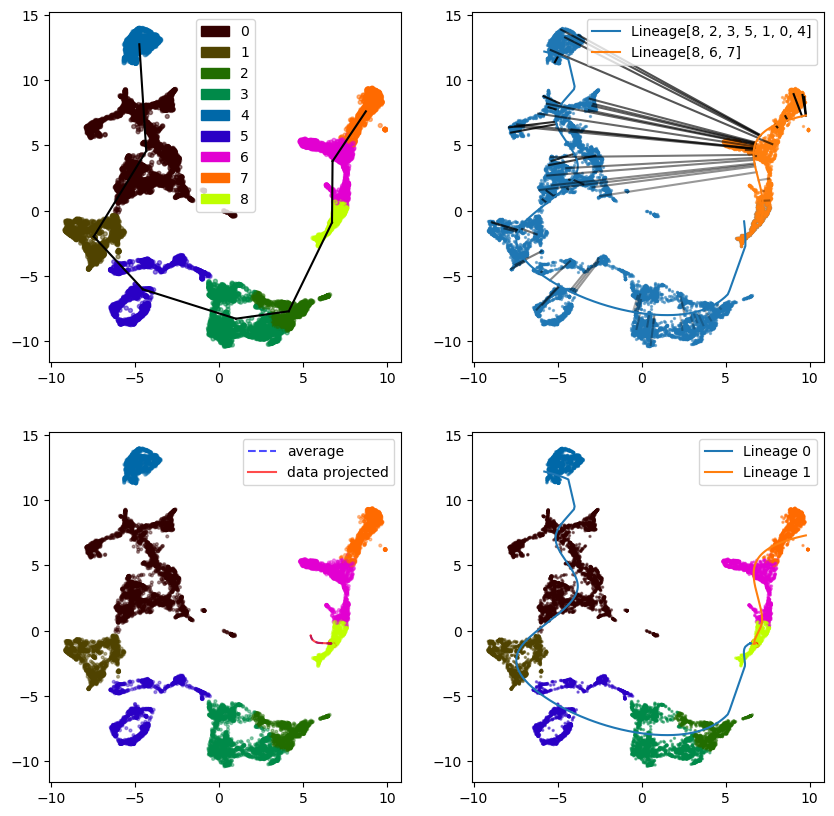

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)
# plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

slingshot = Slingshot(adata, celltype_key="manual_clustering_integer", 
                      obsm_key="X_umap_aligned", start_node=8,
                      debug_level='verbose')

slingshot.fit(num_epochs=1, debug_axes=axes)

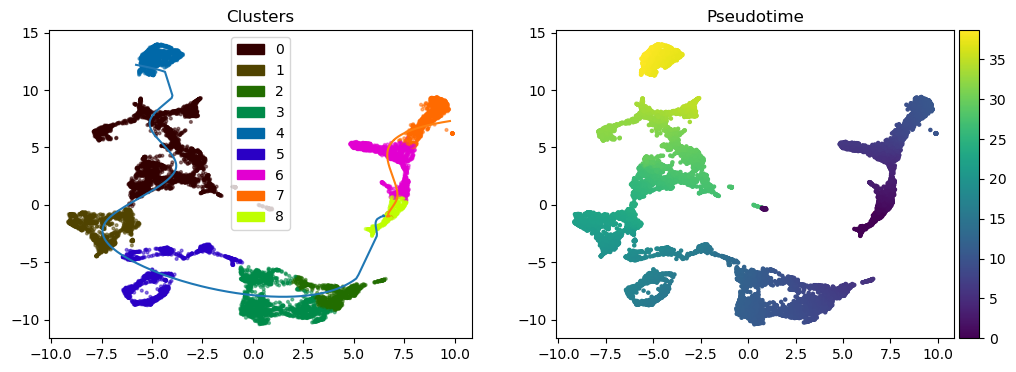

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].set_title('Clusters')
axes[1].set_title('Pseudotime')
slingshot.plotter.curves(axes[0], slingshot.curves)
slingshot.plotter.clusters(axes[0], labels=np.arange(slingshot.num_clusters), s=4, alpha=0.5)
slingshot.plotter.clusters(axes[1], color_mode='pseudotime', s=5)

### get Pseudotime

In [35]:
# NOTE: the Slingshot class has a property which has the pseudotime that is used to 
# color the plot above
pseudotime = slingshot.unified_pseudotime
pseudotime

array([27.28313783, 20.31513414, 25.90464566, ..., 37.81334509,
        2.08358321,  8.81916329])

In [36]:
len(pseudotime)

11824

### map the pseudotime into adata object

In [37]:
adata

AnnData object with n_obs × n_vars = 11824 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'manual_annotation', 'manual_clustering', 'manual_clustering_integer'
    var: 'features'
    uns: 'global_annotation_colors', 'manual_annotation_colors'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna', 'X_umap_aligned'

In [38]:
adata.obs["Pseudotime"] = pseudotime

In [39]:
adata.obs.head()

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,nCount_peaks_merged,nFeature_peaks_merged,SCT_weight,peaks_merged_weight,nCount_Gene_Activity,nFeature_Gene_Activity,manual_annotation,manual_clustering,manual_clustering_integer,Pseudotime
AAACAGCCAATAGTCT-1,0,4423.0,1699,55841.0,22094,0.790918,0.60,4.114782,0.21,4330.0,...,33493.0,23843,0.396183,0.603817,31702.0,11385,Neural_Anterior,Neural_Anterior2,0,27.283138
AAACAGCCAATTGAAG-1,0,6565.0,1685,27119.0,12251,0.693839,0.19,4.899660,0.92,4772.0,...,16145.0,13149,0.037702,0.962298,15664.0,7948,Neural_Anterior,Neural_Anterior1,1,20.315134
AAACAGCCACTGACTA-1,0,5111.0,1932,60618.0,22694,0.730821,0.31,4.354075,0.48,4629.0,...,35973.0,24262,0.439445,0.560555,33518.0,11921,Neural_Anterior,Neural_Anterior2,0,25.904646
AAACATGCAACGTGCT-1,0,2662.0,1007,37976.0,16691,0.799681,0.64,4.471974,0.62,3775.0,...,22753.0,17927,0.405072,0.594928,20877.0,9524,Neural_Posterior,Neural_Posterior1,2,7.290178
AAACATGCAAGTGAAC-1,0,3258.0,1096,7389.0,3546,0.519355,0.03,4.758877,0.85,3916.0,...,4215.0,3775,0.308105,0.691895,3753.0,2630,Neural_Anterior,Neural_Anterior2,0,34.027810


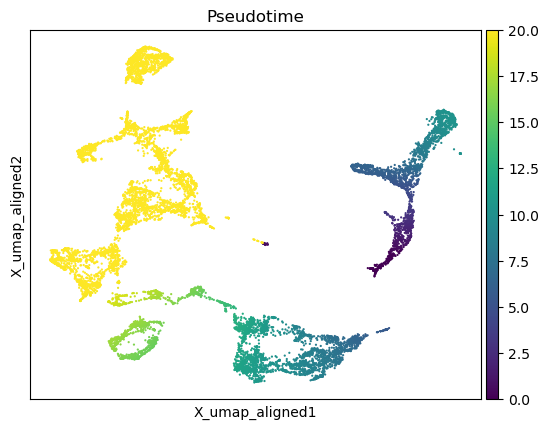

In [40]:
sc.pl.embedding(adata, basis="X_umap_aligned",
                color="Pseudotime", vmax=20)

In [41]:
# add the columns for lineages (mesoderm/neuroectoderm) - used later in CellOracle
Lineage_Meso = ["NMPs","PSM","Somites","Muscle"]
Lineage_NeuroEcto = ["NMPs", "Neural_Posterior", "Neural_Anterior"]

adata.obs["Lineage_Meso"] = adata.obs.manual_annotation.isin(Lineage_Meso)
adata.obs["Lineage_NeuroEcto"] = adata.obs.manual_annotation.isin(Lineage_NeuroEcto)

In [42]:
adata.obs["Lineage_Meso"] = adata.obs.manual_annotation.isin(Lineage_Meso)
adata.obs["Lineage_NeuroEcto"] = adata.obs.manual_annotation.isin(Lineage_NeuroEcto)

In [43]:
# Fill in Pseudotime for Lineage_Meso where Lineage_Meso is True
adata.obs['Pseudotime_Lineage_Meso'] = adata.obs['Pseudotime'].where(adata.obs['Lineage_Meso'], np.nan)

# Fill in Pseudotime for Lineage_NeuroEcto where Lineage_NeuroEcto is True
adata.obs['Pseudotime_Lineage_NeuroEcto'] = adata.obs['Pseudotime'].where(adata.obs['Lineage_NeuroEcto'], np.nan)

In [52]:
adata.obs.head()

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,peaks_merged_weight,nCount_Gene_Activity,nFeature_Gene_Activity,manual_annotation,manual_annotation_integer,Pseudotime,Lineage_Meso,Lineage_NeuroEcto,Pseudotime_Lineage_Meso,Pseudotime_Lineage_NeuroEcto
AAACAGCCATAGACCC-1,0,12581.0,3467,51485.0,19874,0.514213,0.24,5.238692,0.92,5781.0,...,0.427685,26083.0,10345,Neural_Posterior,3,28.662502,False,True,NaN,28.662502
AAACATGCAAACTCAT-1,0,5642.0,2145,19812.0,9183,0.673319,0.85,4.409525,0.41,5363.0,...,0.518235,11748.0,6534,Neural_Posterior,3,6.997933,False,True,NaN,6.997933
AAACATGCAAGGACCA-1,0,2691.0,838,5182.0,2565,0.394904,0.06,4.939061,0.83,4727.0,...,0.591535,3061.0,2376,Neural_Anterior,2,305.624321,False,True,NaN,305.624321
AAACATGCAAGGATTA-1,0,4233.0,1703,24072.0,10949,0.642451,0.72,4.636479,0.62,4729.0,...,0.392159,13152.0,7376,Neural_Anterior,2,183.908195,False,True,NaN,183.908195
AAACATGCAGGACCTT-1,0,14247.0,3236,8685.0,4214,0.477004,0.18,4.089459,0.17,5540.0,...,0.520593,5882.0,3931,PSM,4,5.059997,True,False,5.059997,NaN


In [45]:
filepath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/"
data_id = "TDR125reseq_NMPs"

# save the adata.obs as a dataframe (csv file) for further analysis
adata.obs.to_csv(filepath + f"{data_id}_slingshot.csv")

# save the updated adata object
adata.write_h5ad(filepath + f"{data_id}_pyslingshot.h5ad")

### TDR124reseq (30-somites)

In [46]:
adata = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/TDR124reseq_NMPs.h5ad")
adata

AnnData object with n_obs × n_vars = 4967 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'manual_annotation'
    var: 'features'
    uns: 'global_annotation_colors', 'manual_annotation_colors'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna', 'X_umap_aligned'

In [153]:
# load the annotation
clustering = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/annotations/30somites_manual_clustering.txt", index_col=0, sep="\t")
clustering

adata.obs["manual_clustering"] = clustering

categories = adata.obs['manual_clustering'].unique()

# Create a dictionary mapping each category to an integer
category_to_integer = {category: i for i, category in enumerate(categories)}

# Print the mapping to verify
print(category_to_integer)

# Replace the categorical labels in the DataFrame with the mapped integers
adata.obs['manual_clustering_integer'] = adata.obs['manual_clustering'].map(category_to_integer)

{'Neural_Anterior1': 0, 'PSM1': 1, 'Neural_Posterior2': 2, 'Neural_Posterior1': 3, 'Neural_Posterior3': 4, 'Somites': 5, 'NMPs': 6, 'PSM2': 7, 'NMP2': 8}


/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/pyslingshot/util.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isint(cluster_labels[0]):


Lineages: [Lineage[6, 3, 2, 4, 0], Lineage[6, 8, 1, 7, 5]]


  0%|          | 0/1 [00:00<?, ?it/s]/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/pyslingshot/slingshot.py:333: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D


Reversing from leaf to root
Averaging branch @6 with lineages: [0, 1] [<pcurvepy2.pcurve.PrincipalCurve object at 0x15333f27a7a0>, <pcurvepy2.pcurve.PrincipalCurve object at 0x1533406f4730>]
Shrinking branch @6 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x15333f27a7a0>, <pcurvepy2.pcurve.PrincipalCurve object at 0x1533406f4730>]


100%|██████████| 1/1 [00:17<00:00, 17.67s/it]


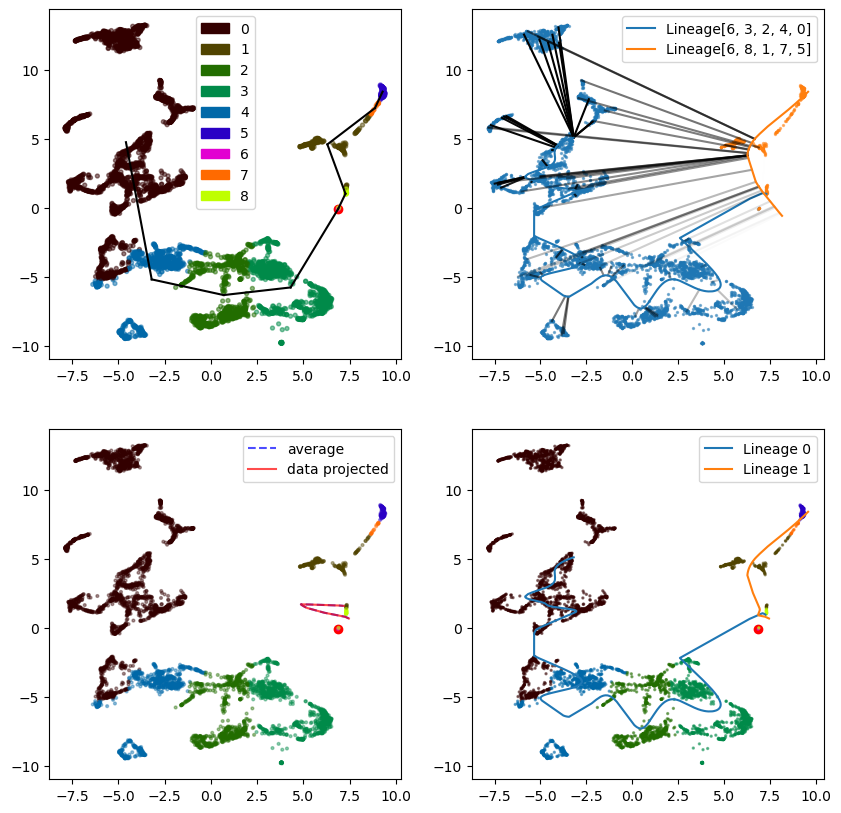

In [154]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)
# plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

slingshot = Slingshot(adata, celltype_key="manual_clustering_integer", 
                      obsm_key="X_umap_aligned", start_node=6, #end_nodes=[6, 2],
                      debug_level='verbose')

slingshot.fit(num_epochs=1, debug_axes=axes)
# slingshot.fit(num_epochs=1)

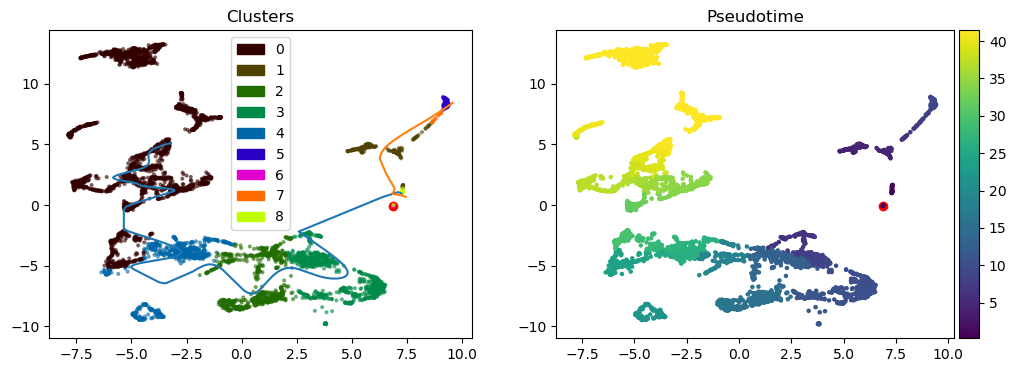

In [155]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].set_title('Clusters')
axes[1].set_title('Pseudotime')
slingshot.plotter.curves(axes[0], slingshot.curves)
slingshot.plotter.clusters(axes[0], labels=np.arange(slingshot.num_clusters), s=4, alpha=0.5)
slingshot.plotter.clusters(axes[1], color_mode='pseudotime', s=5)

### get Pseudotime

In [156]:
# NOTE: the Slingshot class has a property which has the pseudotime that is used to 
# color the plot above
pseudotime = slingshot.unified_pseudotime
pseudotime

array([29.54504177,  4.23398977, 41.44093396, ...,  7.01797761,
       10.17812905, 15.19377112])

In [157]:
len(pseudotime)

4967

### map the pseudotime into adata object

In [158]:
adata

AnnData object with n_obs × n_vars = 4967 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'manual_annotation', 'manual_clustering', 'manual_clustering_integer'
    var: 'features'
    uns: 'global_annotation_colors', 'manual_annotation_colors'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna', 'X_umap_aligned'

In [159]:
adata.obs["Pseudotime"] = pseudotime

In [160]:
adata.obs.head()

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,nCount_peaks_merged,nFeature_peaks_merged,SCT_weight,peaks_merged_weight,nCount_Gene_Activity,nFeature_Gene_Activity,manual_annotation,manual_clustering,manual_clustering_integer,Pseudotime
AAACAGCCAAGGCCAA-1,0,2467.0,864,15766.0,7150,0.537764,0.47,5.046018,0.78,3141.0,...,9380.0,7805,0.415370,0.584630,9555.0,5453,Neural_Anterior,Neural_Anterior1,0,29.545042
AAACAGCCAATATAGG-1,0,2364.0,737,9083.0,4331,0.428235,0.10,5.856213,0.97,3137.0,...,5484.0,4830,0.161655,0.838345,5756.0,3747,Somites,PSM1,1,4.233990
AAACAGCCACCTAATG-1,0,2766.0,943,12016.0,5578,0.511070,0.36,4.754370,0.59,3212.0,...,7086.0,6061,0.500000,0.500000,6866.0,4291,Neural_Anterior,Neural_Anterior1,0,41.440934
AAACAGCCAGCATGAG-1,0,2975.0,900,11517.0,5219,0.494208,0.28,4.238098,0.19,3275.0,...,6750.0,5709,0.389287,0.610713,6644.0,4128,Neural_Posterior,Neural_Posterior2,2,15.919587
AAACAGCCATTGACAT-1,0,3780.0,1151,16791.0,7525,0.554734,0.54,4.178932,0.16,3556.0,...,9875.0,8161,0.199586,0.800414,9878.0,5545,Neural_Posterior,Neural_Posterior1,3,8.216425


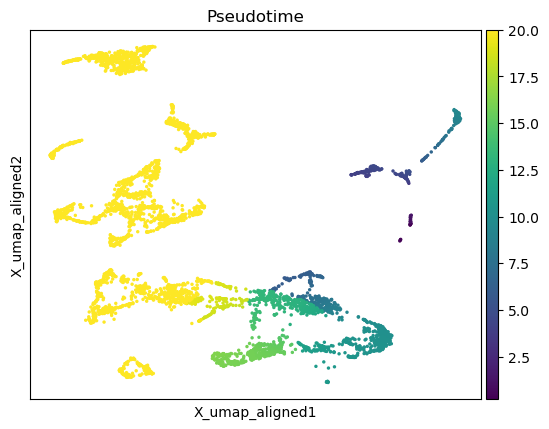

In [161]:
sc.pl.embedding(adata, basis="X_umap_aligned",
                color="Pseudotime", vmax=20)

In [163]:
# add the columns for lineages (mesoderm/neuroectoderm) - used later in CellOracle
Lineage_Meso = ["NMPs","PSM","Somites","Muscle"]
Lineage_NeuroEcto = ["NMPs", "Neural_Posterior", "Neural_Anterior"]

adata.obs["Lineage_Meso"] = adata.obs.manual_annotation.isin(Lineage_Meso)
adata.obs["Lineage_NeuroEcto"] = adata.obs.manual_annotation.isin(Lineage_NeuroEcto)

In [164]:
adata.obs["Lineage_Meso"] = adata.obs.manual_annotation.isin(Lineage_Meso)
adata.obs["Lineage_NeuroEcto"] = adata.obs.manual_annotation.isin(Lineage_NeuroEcto)

In [165]:
# Fill in Pseudotime for Lineage_Meso where Lineage_Meso is True
adata.obs['Pseudotime_Lineage_Meso'] = adata.obs['Pseudotime'].where(adata.obs['Lineage_Meso'], np.nan)

# Fill in Pseudotime for Lineage_NeuroEcto where Lineage_NeuroEcto is True
adata.obs['Pseudotime_Lineage_NeuroEcto'] = adata.obs['Pseudotime'].where(adata.obs['Lineage_NeuroEcto'], np.nan)

In [52]:
adata.obs.head()

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,peaks_merged_weight,nCount_Gene_Activity,nFeature_Gene_Activity,manual_annotation,manual_annotation_integer,Pseudotime,Lineage_Meso,Lineage_NeuroEcto,Pseudotime_Lineage_Meso,Pseudotime_Lineage_NeuroEcto
AAACAGCCATAGACCC-1,0,12581.0,3467,51485.0,19874,0.514213,0.24,5.238692,0.92,5781.0,...,0.427685,26083.0,10345,Neural_Posterior,3,28.662502,False,True,NaN,28.662502
AAACATGCAAACTCAT-1,0,5642.0,2145,19812.0,9183,0.673319,0.85,4.409525,0.41,5363.0,...,0.518235,11748.0,6534,Neural_Posterior,3,6.997933,False,True,NaN,6.997933
AAACATGCAAGGACCA-1,0,2691.0,838,5182.0,2565,0.394904,0.06,4.939061,0.83,4727.0,...,0.591535,3061.0,2376,Neural_Anterior,2,305.624321,False,True,NaN,305.624321
AAACATGCAAGGATTA-1,0,4233.0,1703,24072.0,10949,0.642451,0.72,4.636479,0.62,4729.0,...,0.392159,13152.0,7376,Neural_Anterior,2,183.908195,False,True,NaN,183.908195
AAACATGCAGGACCTT-1,0,14247.0,3236,8685.0,4214,0.477004,0.18,4.089459,0.17,5540.0,...,0.520593,5882.0,3931,PSM,4,5.059997,True,False,5.059997,NaN


In [166]:
filepath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/"
data_id = "TDR124reseq_NMPs"

# save the adata.obs as a dataframe (csv file) for further analysis
adata.obs.to_csv(filepath + f"{data_id}_slingshot.csv")

# save the updated adata object
adata.write_h5ad(filepath + f"{data_id}_pyslingshot.h5ad")

### TDR118reseq (15-somites)

In [167]:
adata = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/TDR118reseq_NMPs_pyslingshot.h5ad")
adata

AnnData object with n_obs × n_vars = 8237 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'manual_annotation'
    var: 'features'
    uns: 'global_annotation_colors', 'manual_annotation_colors'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna', 'X_umap_aligned'

In [177]:
import pandas as pd

clustering = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/annotations/15somites_manual_clustering.txt", index_col=0, sep="\t")
clustering

adata.obs["manual_clustering"] = clustering

categories = adata.obs['manual_clustering'].unique()

# Create a dictionary mapping each category to an integer
category_to_integer = {category: i for i, category in enumerate(categories)}

# Print the mapping to verify
print(category_to_integer)

# Replace the categorical labels in the DataFrame with the mapped integers
adata.obs['manual_clustering_integer'] = adata.obs['manual_clustering'].map(category_to_integer)

{'NP3': 0, 'NP1': 1, 'Neural_Anterior': 2, 'PSM': 3, 'NP4': 4, 'NP2': 5, 'Muscle': 6, 'Somites': 7, 'NMPs': 8}


/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/pyslingshot/util.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isint(cluster_labels[0]):


Lineages: [Lineage[8, 1, 5, 0, 4, 2], Lineage[8, 3, 7, 6]]


  0%|          | 0/1 [00:00<?, ?it/s]/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/pyslingshot/slingshot.py:333: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D


Reversing from leaf to root
Averaging branch @8 with lineages: [0, 1] [<pcurvepy2.pcurve.PrincipalCurve object at 0x15334832cc10>, <pcurvepy2.pcurve.PrincipalCurve object at 0x153348880b20>]
Shrinking branch @8 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x15334832cc10>, <pcurvepy2.pcurve.PrincipalCurve object at 0x153348880b20>]


100%|██████████| 1/1 [00:46<00:00, 46.61s/it]


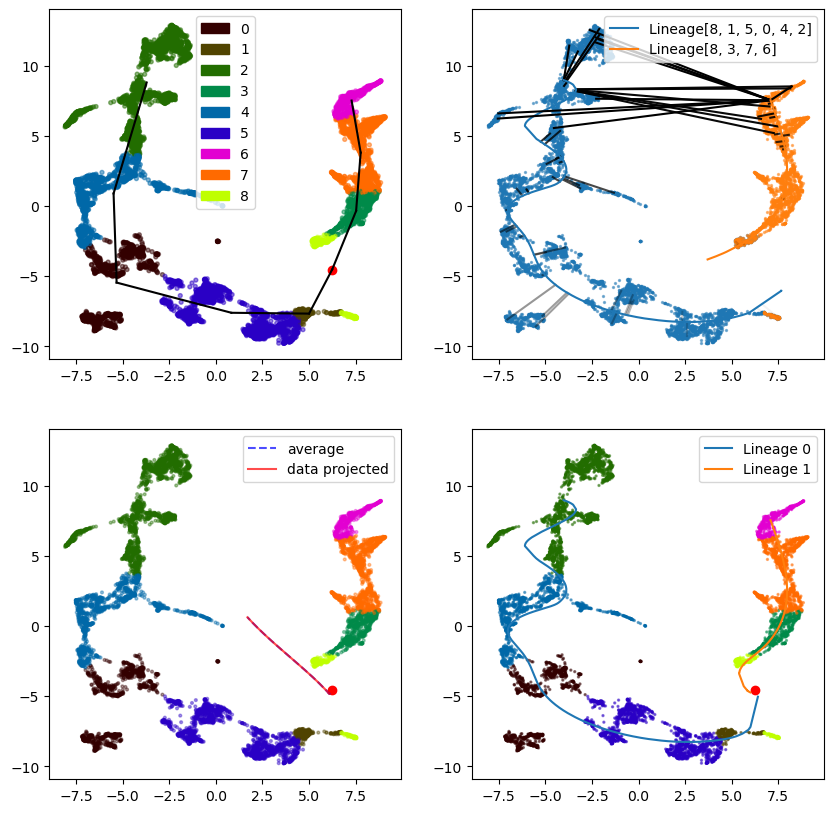

In [178]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)
# plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

slingshot = Slingshot(adata, celltype_key="manual_clustering_integer", 
                      obsm_key="X_umap_aligned", start_node=8,
                      debug_level='verbose')

slingshot.fit(num_epochs=1, debug_axes=axes)

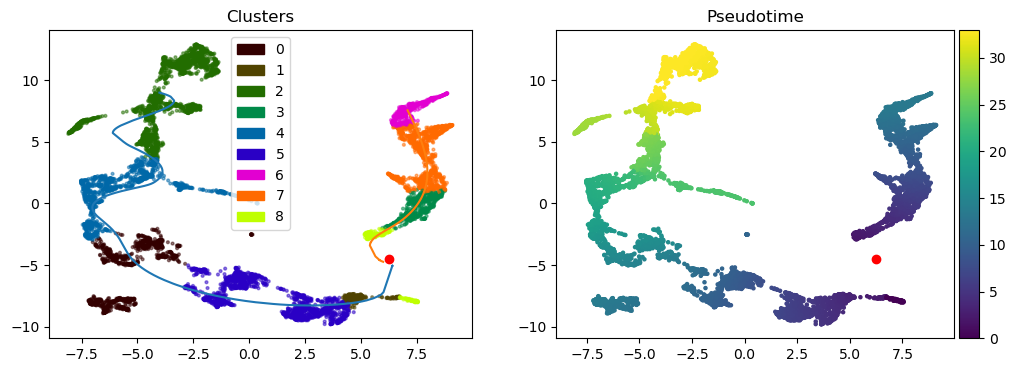

In [179]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].set_title('Clusters')
axes[1].set_title('Pseudotime')
slingshot.plotter.curves(axes[0], slingshot.curves)
slingshot.plotter.clusters(axes[0], labels=np.arange(slingshot.num_clusters), s=4, alpha=0.5)
slingshot.plotter.clusters(axes[1], color_mode='pseudotime', s=5)

### get Pseudotime

In [180]:
# NOTE: the Slingshot class has a property which has the pseudotime that is used to 
# color the plot above
pseudotime = slingshot.unified_pseudotime
pseudotime

array([13.07497818,  3.64123574, 30.45481672, ..., 32.74553268,
       14.62644764, 32.94309748])

In [181]:
len(pseudotime)

8237

### map the pseudotime into adata object

In [182]:
adata

AnnData object with n_obs × n_vars = 8237 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'manual_annotation', 'manual_clustering', 'manual_clustering_integer'
    var: 'features'
    uns: 'global_annotation_colors', 'manual_annotation_colors'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna', 'X_umap_aligned'

In [183]:
adata.obs["Pseudotime"] = pseudotime

In [39]:
adata.obs.head()

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,nCount_peaks_merged,nFeature_peaks_merged,SCT_weight,peaks_merged_weight,nCount_Gene_Activity,nFeature_Gene_Activity,manual_annotation,manual_clustering,manual_clustering_integer,Pseudotime
AAACAGCCAATAGTCT-1,0,4423.0,1699,55841.0,22094,0.790918,0.60,4.114782,0.21,4330.0,...,33493.0,23843,0.396183,0.603817,31702.0,11385,Neural_Anterior,Neural_Anterior2,0,27.283138
AAACAGCCAATTGAAG-1,0,6565.0,1685,27119.0,12251,0.693839,0.19,4.899660,0.92,4772.0,...,16145.0,13149,0.037702,0.962298,15664.0,7948,Neural_Anterior,Neural_Anterior1,1,20.315134
AAACAGCCACTGACTA-1,0,5111.0,1932,60618.0,22694,0.730821,0.31,4.354075,0.48,4629.0,...,35973.0,24262,0.439445,0.560555,33518.0,11921,Neural_Anterior,Neural_Anterior2,0,25.904646
AAACATGCAACGTGCT-1,0,2662.0,1007,37976.0,16691,0.799681,0.64,4.471974,0.62,3775.0,...,22753.0,17927,0.405072,0.594928,20877.0,9524,Neural_Posterior,Neural_Posterior1,2,7.290178
AAACATGCAAGTGAAC-1,0,3258.0,1096,7389.0,3546,0.519355,0.03,4.758877,0.85,3916.0,...,4215.0,3775,0.308105,0.691895,3753.0,2630,Neural_Anterior,Neural_Anterior2,0,34.027810


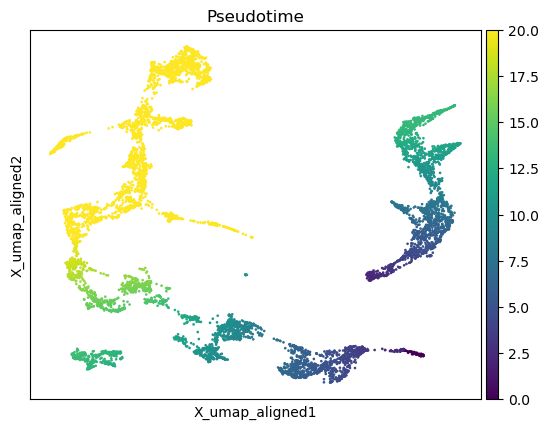

In [184]:
sc.pl.embedding(adata, basis="X_umap_aligned",
                color="Pseudotime", vmax=20)

In [185]:
# add the columns for lineages (mesoderm/neuroectoderm) - used later in CellOracle
Lineage_Meso = ["NMPs","PSM","Somites","Muscle"]
Lineage_NeuroEcto = ["NMPs", "Neural_Posterior", "Neural_Anterior"]

adata.obs["Lineage_Meso"] = adata.obs.manual_annotation.isin(Lineage_Meso)
adata.obs["Lineage_NeuroEcto"] = adata.obs.manual_annotation.isin(Lineage_NeuroEcto)

In [186]:
adata.obs["Lineage_Meso"] = adata.obs.manual_annotation.isin(Lineage_Meso)
adata.obs["Lineage_NeuroEcto"] = adata.obs.manual_annotation.isin(Lineage_NeuroEcto)

In [187]:
# Fill in Pseudotime for Lineage_Meso where Lineage_Meso is True
adata.obs['Pseudotime_Lineage_Meso'] = adata.obs['Pseudotime'].where(adata.obs['Lineage_Meso'], np.nan)

# Fill in Pseudotime for Lineage_NeuroEcto where Lineage_NeuroEcto is True
adata.obs['Pseudotime_Lineage_NeuroEcto'] = adata.obs['Pseudotime'].where(adata.obs['Lineage_NeuroEcto'], np.nan)

In [52]:
adata.obs.head()

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,peaks_merged_weight,nCount_Gene_Activity,nFeature_Gene_Activity,manual_annotation,manual_annotation_integer,Pseudotime,Lineage_Meso,Lineage_NeuroEcto,Pseudotime_Lineage_Meso,Pseudotime_Lineage_NeuroEcto
AAACAGCCATAGACCC-1,0,12581.0,3467,51485.0,19874,0.514213,0.24,5.238692,0.92,5781.0,...,0.427685,26083.0,10345,Neural_Posterior,3,28.662502,False,True,NaN,28.662502
AAACATGCAAACTCAT-1,0,5642.0,2145,19812.0,9183,0.673319,0.85,4.409525,0.41,5363.0,...,0.518235,11748.0,6534,Neural_Posterior,3,6.997933,False,True,NaN,6.997933
AAACATGCAAGGACCA-1,0,2691.0,838,5182.0,2565,0.394904,0.06,4.939061,0.83,4727.0,...,0.591535,3061.0,2376,Neural_Anterior,2,305.624321,False,True,NaN,305.624321
AAACATGCAAGGATTA-1,0,4233.0,1703,24072.0,10949,0.642451,0.72,4.636479,0.62,4729.0,...,0.392159,13152.0,7376,Neural_Anterior,2,183.908195,False,True,NaN,183.908195
AAACATGCAGGACCTT-1,0,14247.0,3236,8685.0,4214,0.477004,0.18,4.089459,0.17,5540.0,...,0.520593,5882.0,3931,PSM,4,5.059997,True,False,5.059997,NaN


In [188]:
filepath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/08_NMPs_subsetted/"
data_id = "TDR118reseq_NMPs"

# save the adata.obs as a dataframe (csv file) for further analysis
adata.obs.to_csv(filepath + f"{data_id}_slingshot.csv")

# save the updated adata object
adata.write_h5ad(filepath + f"{data_id}_pyslingshot.h5ad")